In [1]:
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
source_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Train"
test_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Test"
client_dirs = glob(source_dir+ "/*")

In [3]:
client_dirs

['G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client1',
 'G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client2',
 'G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client3']

In [4]:
input_shape = (128, 128)
batch_size = 32

generators_train_client = []
generators_val_client = []

for i in range(0, len(client_dirs)):
    datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    generator_train = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True)
    generator_val = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True)
    generators_train_client.append(generator_train)
    generators_val_client.append(generator_val)
num_classes = generators_train_client[0].num_classes

Found 4396 images belonging to 15 classes.
Found 1094 images belonging to 15 classes.
Found 4397 images belonging to 15 classes.
Found 1095 images belonging to 15 classes.
Found 4386 images belonging to 15 classes.
Found 1090 images belonging to 15 classes.


In [5]:
datagen_test = ImageDataGenerator(rescale=1./255)
generators_test = datagen_train.flow_from_directory(directory=test_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 4180 images belonging to 15 classes.


In [6]:
class SimpleModel:
    def build(self):
        base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)
        return model


In [7]:
opt = Adam(lr=.00001)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
smlp_global = SimpleModel()
global_model = smlp_global.build()
global_model.compile(optimizer= opt, loss=loss, metrics=metrics)

local_model = smlp_global.build()
local_model.compile(optimizer= opt, loss=loss, metrics=metrics)

In [9]:
local_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [10]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [12]:
comms_round = 10
client_accuracies = [[] for _ in range(len(generators_train_client))]  # List to store accuracies for each client

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = []
    print("Round: ", comm_round)
    
    for client in range(len(generators_train_client)):
        print("Client: ", client + 1)
        local_model.set_weights(global_weights)
        steps_per_epoch = generators_train_client[client].n // batch_size
        steps_val = generators_val_client[client].n // batch_size
        
        # Fit model with early stopping
        history = local_model.fit(generators_train_client[client],
                                  epochs=5,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generators_val_client[client],
                                  validation_steps=steps_val,
                                  callbacks=[early_stopping])  # Add early stopping here

        # Append accuracy after each epoch to the respective client's accuracy list
        client_accuracies[client].extend(history.history['val_categorical_accuracy'])
        
        # Scale local weights and append to list
        scaled_local_weights = scale_model_weights(local_model.get_weights(), 1 / len(client_dirs))
        scaled_local_weight_list.append(scaled_local_weights)
    
    # Average the scaled weights and update the global model
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    
    scores = global_model.evaluate(generators_test)
    print("Communication round " + str(comm_round) + " global model accuracy is " + str(scores[1] * 100))


Round:  0
Client:  1
Epoch 1/5
137/137 [==============================] - 14s 104ms/step - loss: 2.3865 - categorical_accuracy: 0.2981 - val_loss: 2.5343 - val_categorical_accuracy: 0.2408
Epoch 2/5
137/137 [==============================] - 12s 91ms/step - loss: 1.2381 - categorical_accuracy: 0.6512 - val_loss: 2.2502 - val_categorical_accuracy: 0.3134
Epoch 3/5
137/137 [==============================] - 14s 102ms/step - loss: 0.8035 - categorical_accuracy: 0.7951 - val_loss: 2.0347 - val_categorical_accuracy: 0.3732
Epoch 4/5
137/137 [==============================] - 13s 91ms/step - loss: 0.5584 - categorical_accuracy: 0.8689 - val_loss: 1.8191 - val_categorical_accuracy: 0.4449
Epoch 5/5
137/137 [==============================] - 13s 91ms/step - loss: 0.4275 - categorical_accuracy: 0.9026 - val_loss: 1.6417 - val_categorical_accuracy: 0.5147
Client:  2
Epoch 1/5
137/137 [==============================] - 84s 617ms/step - loss: 2.3411 - categorical_accuracy: 0.3205 - val_loss: 2.468

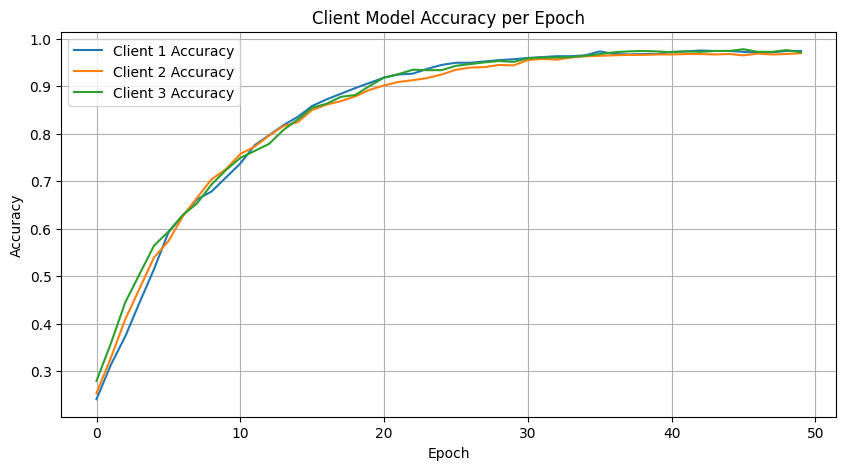

In [13]:
# Plot accuracy graph for each client
plt.figure(figsize=(10, 5))
for client in range(len(client_accuracies)):
    plt.plot(client_accuracies[client], label=f'Client {client + 1} Accuracy')
plt.title('Client Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

131/131 [==============================] - 4s 26ms/step


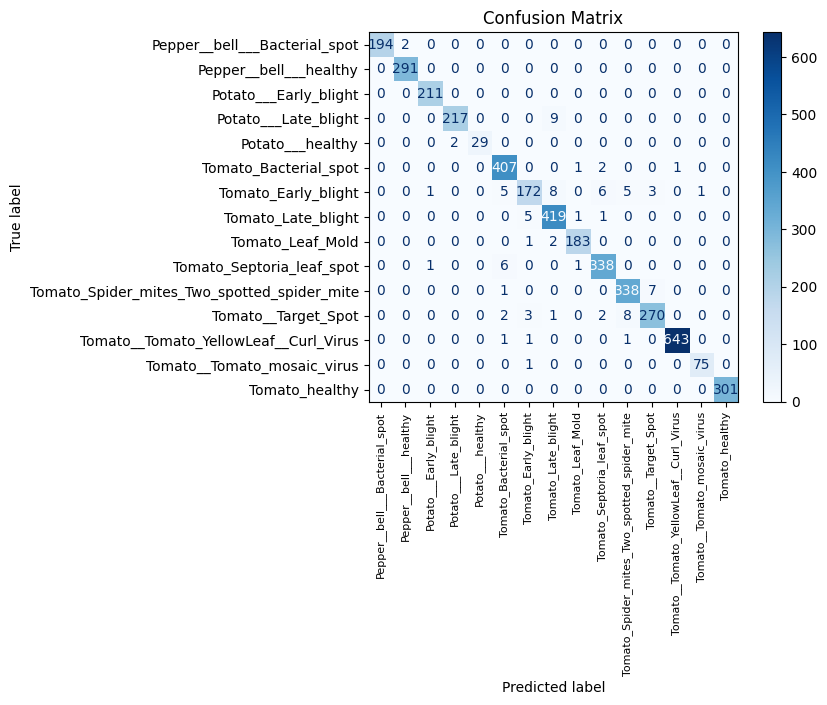

Final Accuracy: 97.7990448474884
Final F1-score: 97.7815468111352
Final Precision: 97.79869828672881
Final Recall: 97.79904306220095


In [14]:
scores = global_model.evaluate(generators_test)
final_accuracy = scores[1]

# Calculate predictions
predictions = global_model.predict(generators_test)
y_true = generators_test.classes
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(generators_test.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(fontsize=8, rotation=90)
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1-score
final_precision = precision_score(y_true, y_pred, average='weighted')
final_recall = recall_score(y_true, y_pred, average='weighted')
final_f1 = f1_score(y_true, y_pred, average='weighted')

# Print final results
print("Final Accuracy:", final_accuracy * 100)
print("Final F1-score:", final_f1 * 100)
print("Final Precision:", final_precision * 100)
print("Final Recall:", final_recall * 100)

In [15]:
global_model.save(r'G:/BracU/Thesis/Weights/PlantVillage/mobilenetV2')
print("Model saved successfully.")


INFO:tensorflow:Assets written to: G:/BracU/Thesis/Weights/PlantVillage/mobilenetV2\assets


INFO:tensorflow:Assets written to: G:/BracU/Thesis/Weights/PlantVillage/mobilenetV2\assets


Model saved successfully.
